In [1]:
import boto3
import datetime
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [2]:
# Getting the infer files
start_date_str = '2023-06-27'
end_date_str = '2023-06-27'
organization_id = 'hamid'
k3y_id = '17700cf8'

# start_date_str = '2023-05-29'
# end_date_str = '2023-06-03'
# organization_id = 'hamid'
# k3y_id = '78f8031e'
# k3y_id = '9ed5b50e'

start_time_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_time_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y-' + k3y_id + '/infer/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and len(file.split('/')[-1].split('.')[0]) != 10
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0].split('_')[-1], '%Y-%m-%d') >= start_time_date
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0].split('_')[-1], '%Y-%m-%d') <= end_time_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    imu_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(imu_df)
imu_df = pd.concat(df_list, axis=0, ignore_index=True)

print(imu_df.columns)

Index(['imu_sw_clock(epoch)', 'system_clock(epoch)', 'diff_sw_sys(second)',
       ' counter', 'temp(C)', 'motion_state'],
      dtype='object')


264.72448444366455
264.72448444366455


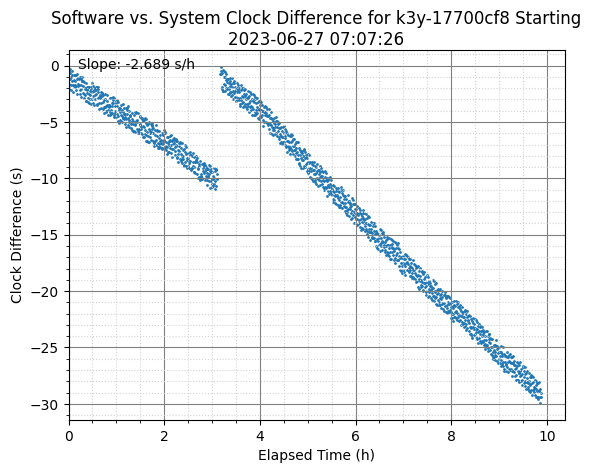

In [3]:
# plot the clock difference

write_sw_slope = True

# drop any nan values
imu_df.dropna(inplace=True)
imu_df.reset_index(drop=True, inplace=True)

# imu_df = imu_df[:3000]

# process any gaps in the data so it has the correct start time
stale_time = 60000000
max_jump = imu_df['system_clock(epoch)'].diff().max()
print(max_jump)
while(max_jump > stale_time):
    time_jump_index = imu_df['system_clock(epoch)'].diff().argmax()
    imu_df = imu_df.iloc[time_jump_index :].reset_index(drop=True)
    max_jump = imu_df['system_clock(epoch)'].diff().max()
print(max_jump)

# create new column to display an offset time in hours
start_time = imu_df['system_clock(epoch)'].min()
imu_df['adjusted_time'] = (imu_df['system_clock(epoch)']-start_time)/3600

# get start time date
start_time_dt = datetime.datetime.fromtimestamp(start_time)
start_time_date = start_time_dt.strftime("%Y-%m-%d %H:%M:%S")

# plot software data and write labels
fig, ax = plt.subplots()
ax.scatter(x=imu_df['adjusted_time'], y=imu_df['diff_sw_sys(second)'], s=1)
plt.title(f'Software vs. System Clock Difference for k3y-{k3y_id} Starting {start_time_date}', wrap = True)
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Clock Difference (s)')

# set gridlines
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', color='grey', linestyle='-')
ax.grid(which='minor', color='lightgrey', linestyle=':')
ax.set_xlim(left=0)

if write_sw_slope:
    m, b = np.polyfit(imu_df['adjusted_time'], imu_df['diff_sw_sys(second)'], 1)
    plt.text(0.02, 0.95, f'Slope: {m:.3f} s/h', transform=plt.gca().transAxes)

plt.show()

Aiming to process the gaps to get different slope values

Index([471, 1486], dtype='int64')
[{'start_timestamp': 0.0, 'end_timestamp': 3.174560877548324, 'slope': -2.906359485410154}, {'start_timestamp': 3.174560877548324, 'end_timestamp': 9.874254261255265, 'slope': -4.25377773555731}]
2


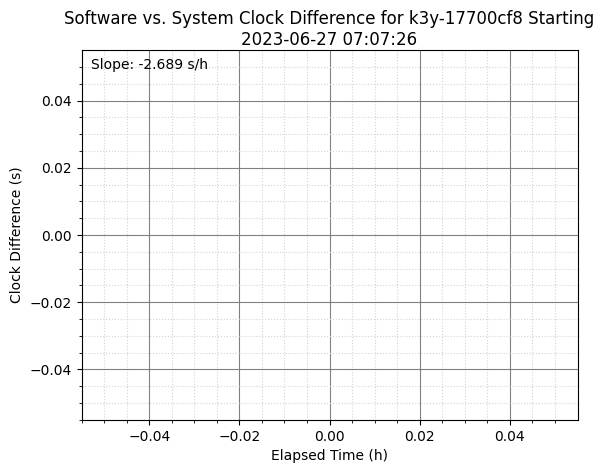

In [4]:
write_sw_slope = True

# drop any nan values
imu_df.dropna(inplace=True)
imu_df.reset_index(drop=True, inplace=True)

# imu_df[:1000].to_csv('test_output.csv')

jump_limit = 2
jump_indexes = imu_df[abs(imu_df['diff_sw_sys(second)'].diff()) > jump_limit].index
jump_indexes = jump_indexes.append(pd.Index([imu_df.index[-1]]))
print(jump_indexes)

segments = []
index_start = 0
for index in jump_indexes:
    seg_data = {}
    seg_data['start_timestamp'] = imu_df['adjusted_time'].iloc[index_start]
    seg_data['end_timestamp'] = imu_df['adjusted_time'].iloc[index]
    seg_data['slope'] = np.polyfit(imu_df['adjusted_time'][index_start:index], imu_df['diff_sw_sys(second)'][index_start:index], 1)[0]
    segments.append(seg_data)
    index_start = index
print(segments)
print(len(segments))

# create new column to display an offset time in hours
start_time = imu_df['system_clock(epoch)'].min()
imu_df['adjusted_time'] = (imu_df['system_clock(epoch)']-start_time)/3600

# get start time date
start_time_dt = datetime.datetime.fromtimestamp(start_time)
start_time_date = start_time_dt.strftime("%Y-%m-%d %H:%M:%S")

# plot software data and write labels
fig, ax = plt.subplots()
ax.scatter(x=imu_df[imu_df['adjusted_time'] >= 1685661425.227717]['adjusted_time'], y=imu_df[imu_df['adjusted_time'] >= 1685661425.227717]['diff_sw_sys(second)'], s=1)
plt.title(f'Software vs. System Clock Difference for k3y-{k3y_id} Starting {start_time_date}', wrap = True)
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Clock Difference (s)')

# set gridlines
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', color='grey', linestyle='-')
ax.grid(which='minor', color='lightgrey', linestyle=':')
# ax.set_xlim(left=0)

if write_sw_slope:
    m, b = np.polyfit(imu_df['adjusted_time'], imu_df['diff_sw_sys(second)'], 1)
    plt.text(0.02, 0.95, f'Slope: {m:.3f} s/h', transform=plt.gca().transAxes)

plt.show()